In [1]:
import multimodal_cci as mmcci
import scanpy as sc

#### Load stLearn data objects

In [2]:
brain_aged_tech1 = [
    sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP40_1C_CCI.h5ad"),
    sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP40_1D_CCI.h5ad"),
    sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP41_1B_CCI.h5ad"),
    sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP41_1D_CCI.h5ad")
    ]

brain_young_tech1 = [
    sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP40_1A_CCI.h5ad"),
    sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP40_1B_CCI.h5ad"),
    sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP41_1A_CCI.h5ad"),
    sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP41_1C_CCI.h5ad")
    ]

brain_aged_tech2 = [
    sc.read_h5ad("/QRISdata/Q5058/sMACS/STomics/Processed/Brain/CCI_new/brain_A1_CCI_bin80.h5ad"),
    sc.read_h5ad("/QRISdata/Q5058/sMACS/STomics/Processed/Brain/CCI_new/brain_A4_CCI_bin80.h5ad")
    ]
brain_young_tech2 = [
    sc.read_h5ad("/QRISdata/Q5058/sMACS/STomics/Processed/Brain/CCI_new/brain_Y1_CCI_bin80.h5ad"),
    sc.read_h5ad("/QRISdata/Q5058/sMACS/STomics/Processed/Brain/CCI_new/brain_Y4_CCI_bin80.h5ad")
    ]

brain_aged_tech1_cci = [sample.uns['per_lr_cci_cell_type'] for sample in brain_aged_tech1]
brain_young_tech1_cci = [sample.uns['per_lr_cci_cell_type'] for sample in brain_young_tech1]
brain_aged_tech2_cci = [sample.uns['per_lr_cci_cell_type'] for sample in brain_aged_tech2]
brain_young_tech2_cci = [sample.uns['per_lr_cci_cell_type'] for sample in brain_young_tech2]

brain_aged_tech1_sizes = [sample.shape[0] for sample in brain_aged_tech1]
brain_young_tech1_sizes = [sample.shape[0] for sample in brain_young_tech1]
brain_aged_tech2_sizes = [sample.shape[0] for sample in brain_aged_tech2]
brain_young_tech2_sizes = [sample.shape[0] for sample in brain_young_tech2]

In [3]:
from matplotlib import pyplot as plt

colors = {
    'Ependymal': plt.colormaps.get_cmap('tab10').colors[0],
    'Astrocytes': plt.colormaps.get_cmap('tab10').colors[1],
    'Vascular': plt.colormaps.get_cmap('tab10').colors[2],
    'Oligos': plt.colormaps.get_cmap('tab10').colors[3],
    'Neurons': plt.colormaps.get_cmap('tab10').colors[4],
    'Microglia': plt.colormaps.get_cmap('tab10').colors[5],
    'Immune': plt.colormaps.get_cmap('tab10').colors[6]
}

#### Normalise each group of samples

In [4]:
brain_aged_tech1_normalised = mmcci.it.normalise_within_tech(brain_aged_tech1_cci, brain_aged_tech1_sizes, target=brain_young_tech1_sizes[0])
brain_young_tech1_normalised = mmcci.it.normalise_within_tech(brain_young_tech1_cci, brain_young_tech1_sizes, target=brain_young_tech1_sizes[0])
brain_aged_tech2_normalised = mmcci.it.normalise_within_tech(brain_aged_tech2_cci, brain_aged_tech2_sizes, target=brain_young_tech2_sizes[0])
brain_young_tech2_normalised = mmcci.it.normalise_within_tech(brain_young_tech2_cci, brain_young_tech2_sizes, target=brain_young_tech2_sizes[0])

In [5]:
# for sample in brain_young_tech2_normalised:
#     overall_sample = mmcci.it.calculate_overall_interactions(sample)
#     mmcci.plt.network_plot(overall_sample, text_size=26, node_size=1500, edge_weight=30, node_label_dist=1.1)

#### Integrate within technologies

In [6]:
brain_aged_tech1_integrated = mmcci.it.integrate_samples(brain_aged_tech1_normalised)
brain_young_tech1_integrated = mmcci.it.integrate_samples(brain_young_tech1_normalised)
brain_aged_tech2_integrated = mmcci.it.integrate_samples(brain_aged_tech2_normalised)
brain_young_tech2_integrated = mmcci.it.integrate_samples(brain_young_tech2_normalised)

In [7]:
# overall_sample = mmcci.it.calculate_overall_interactions(brain_young_tech2_integrated)
# mmcci.plt.network_plot(overall_sample, text_size=26, node_size=1500, edge_weight=30, node_label_dist=1.1)

#### Normalise samples between technologies

In [8]:
aged_normalised = mmcci.it.normalise_between_tech([brain_aged_tech1_integrated, brain_aged_tech2_integrated])
young_normalised = mmcci.it.normalise_between_tech([brain_young_tech1_integrated, brain_young_tech2_integrated])

#### Integrate between technologies for both groups

In [9]:
aged_integrated = mmcci.it.integrate_samples(aged_normalised)
young_integrated = mmcci.it.integrate_samples(young_normalised)

#### Calculate overall interactions network per group

In [10]:
aged_overall = mmcci.it.calculate_overall_interactions(aged_integrated)
young_overall = mmcci.it.calculate_overall_interactions(young_integrated)

# mmcci.plt.network_plot(aged_overall, text_size=26, node_size=1500, edge_weight=30, node_label_dist=1.1)
# mmcci.plt.network_plot(young_overall, text_size=26, node_size=1500, edge_weight=30, node_label_dist=1.1)

# mmcci.plt.chord_plot(aged_overall, colors=colors)
# mmcci.plt.chord_plot(young_overall, colors=colors)

#### Rank LR pairs based on dissimilarity between groups

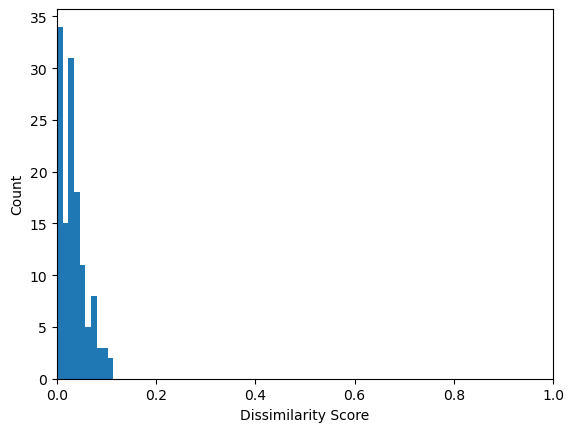

Overall Network Aged vs Young Dissimilarity Score is: 0.23906891519232853


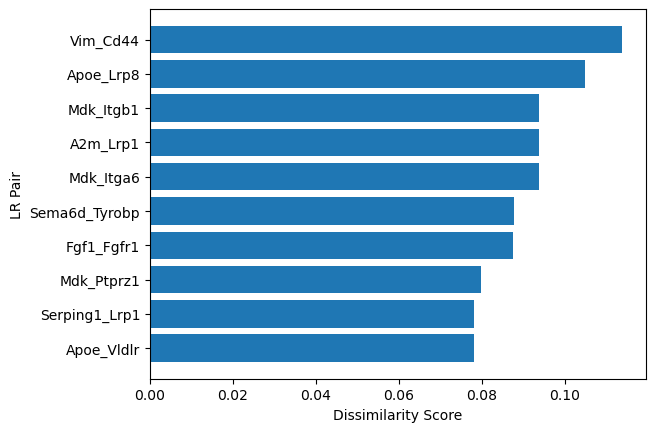

In [11]:
dissimilarity_scores = mmcci.an.calculate_dissim(aged_integrated, young_integrated)
mmcci.plt.dissim_hist(dissimilarity_scores)
    
## Sort LR Pairs from high to low dissimilarities
print("Overall Network Aged vs Young Dissimilarity Score is: " + str(mmcci.sc.dissimilarity_score(aged_overall, young_overall)))

mmcci.plt.lr_top_dissimilarity(dissimilarity_scores)

#### Plot highly dissimilar pairs between groups

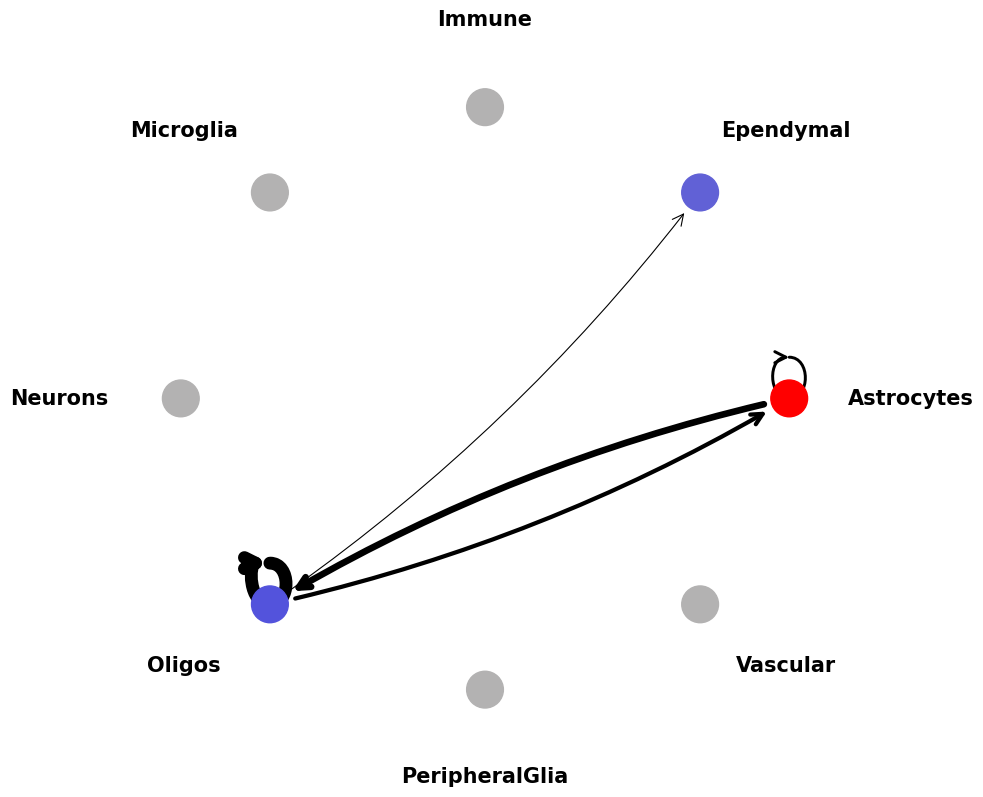

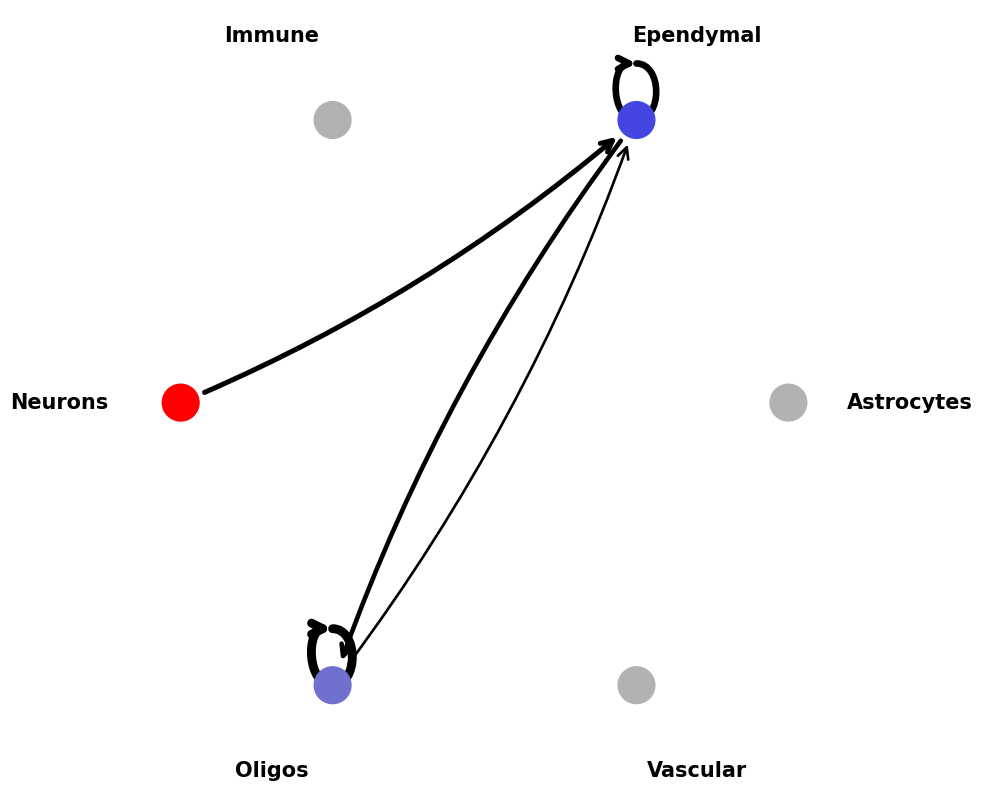

In [12]:
mmcci.plt.network_plot(aged_integrated['Vim_Cd44'])
mmcci.plt.network_plot(young_integrated['Vim_Cd44'])

#### Calculate p values for significance changes between groups

In [13]:
p_values = mmcci.an.perm_test(aged_overall, young_overall)
p_values

,Astrocytes,Ependymal,Immune,Microglia,Neurons,Oligos,PeripheralGlia,Vascular
Astrocytes,0.055135,0.243130,0.241775,0.24155,0.070785,0.195405,0.243105,0.243305
Ependymal,0.217530,0.031905,0.242750,0.24315,0.124670,0.219055,0.242430,0.242080
Immune,0.241040,0.242650,0.242370,0.24206,0.240975,0.241625,0.243095,0.243105
Microglia,0.241470,0.242800,0.240700,0.24187,0.241925,0.241345,0.242900,0.242470
Neurons,0.094360,0.126580,0.244290,0.24163,0.038375,0.140015,0.242390,0.218935
Oligos,0.195130,0.218815,0.242405,0.24240,0.155090,0.007405,0.241340,0.241475
PeripheralGlia,0.241735,0.244065,0.241490,0.24069,0.240525,0.243410,0.242185,0.241605
Vascular,0.219070,0.242020,0.241755,0.24310,0.202765,0.243940,0.241900,0.241445


#### Plot aged and young overall networks

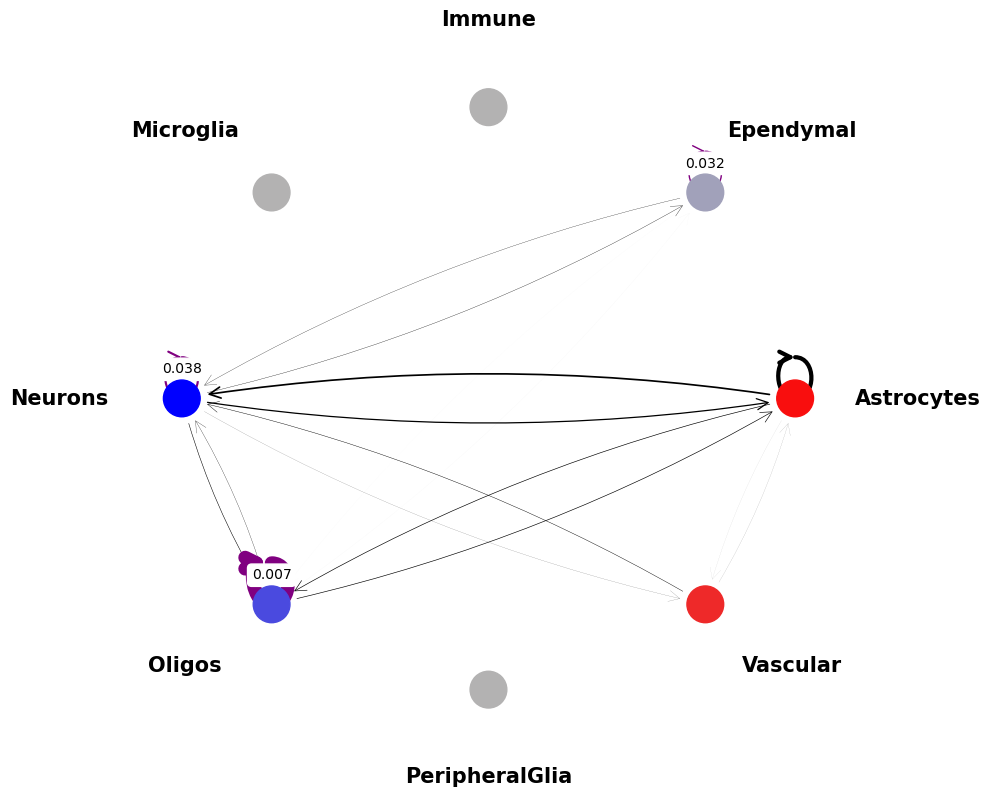

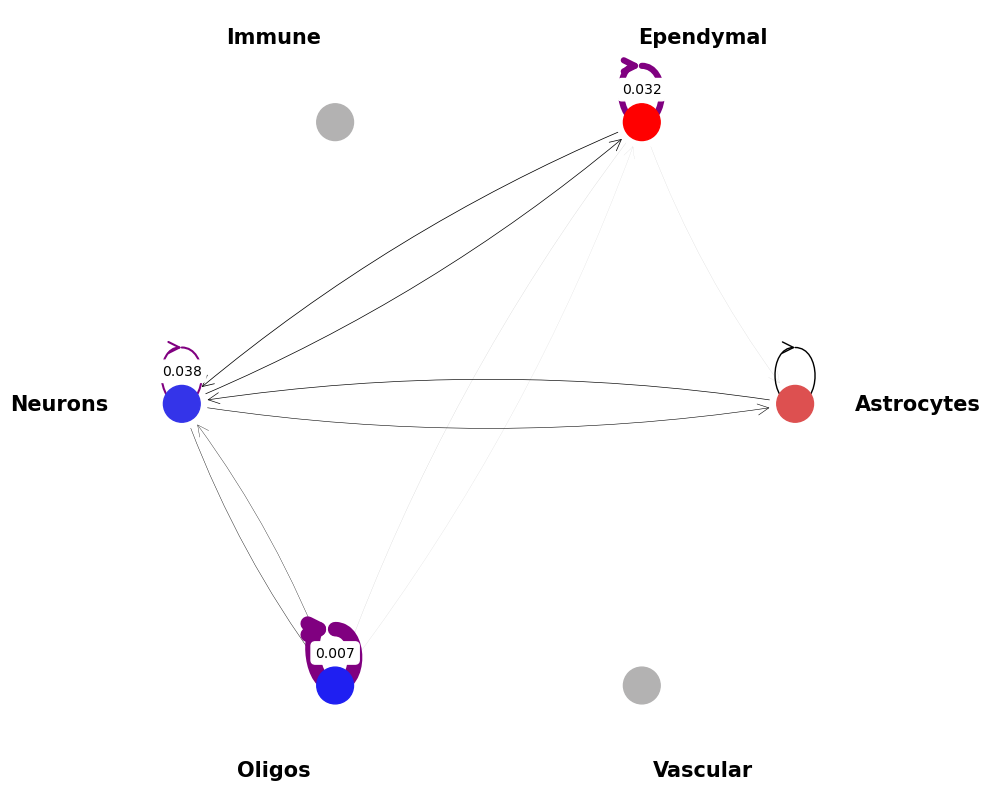

In [14]:
mmcci.plt.network_plot(aged_overall, p_values)
mmcci.plt.network_plot(young_overall, p_values)

#### Get LR pairs from Astrocytes to Neurons

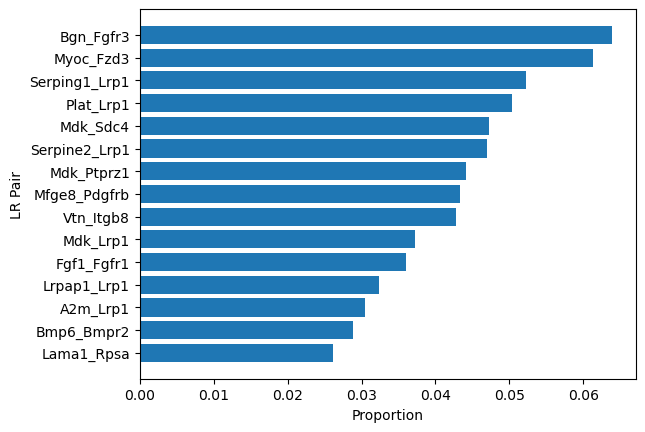

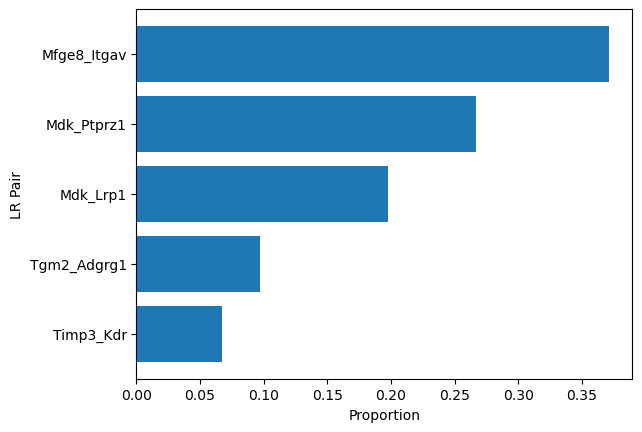

In [17]:
mmcci.plt.lrs_per_celltype(aged_integrated, "Astrocytes", "Neurons", n=15)
mmcci.plt.lrs_per_celltype(young_integrated, "Astrocytes", "Neurons", n=15)

#### Cluster Aged and Young LR Pairs

Computing Dissimilarity Scores for multiple interactions...


Processing: 100%|██████████| 131/131 [00:06<00:00, 19.57it/s]


Computing Principal Components of weighted graph ...
Performing Clustering and Ranking within clusters...


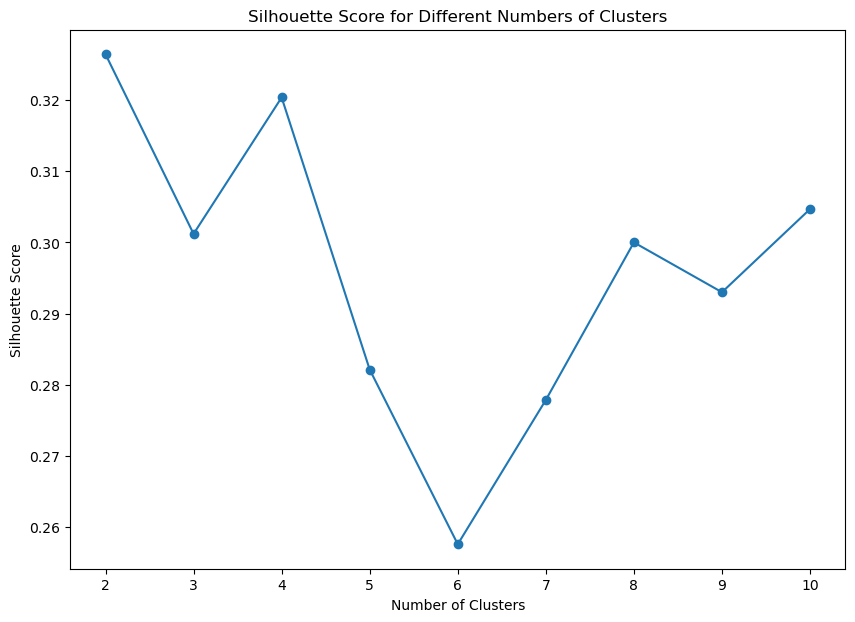

Computing Dissimilarity Scores for single interactions...


Processing: 100%|██████████| 154/154 [00:08<00:00, 18.25it/s]


Computing Principal Components of weighted graph ...
Performing Clustering and Ranking within clusters...


In [18]:
aged_clusters = mmcci.an.lr_grouping(aged_integrated, n_clusters=0)
aged_integrated_clusters = mmcci.an.subset_clusters(aged_integrated, aged_clusters)
aged_overall_clusters = mmcci.an.calculate_cluster_interactions(aged_integrated_clusters)


cluster0: Contains 78 LR pairs


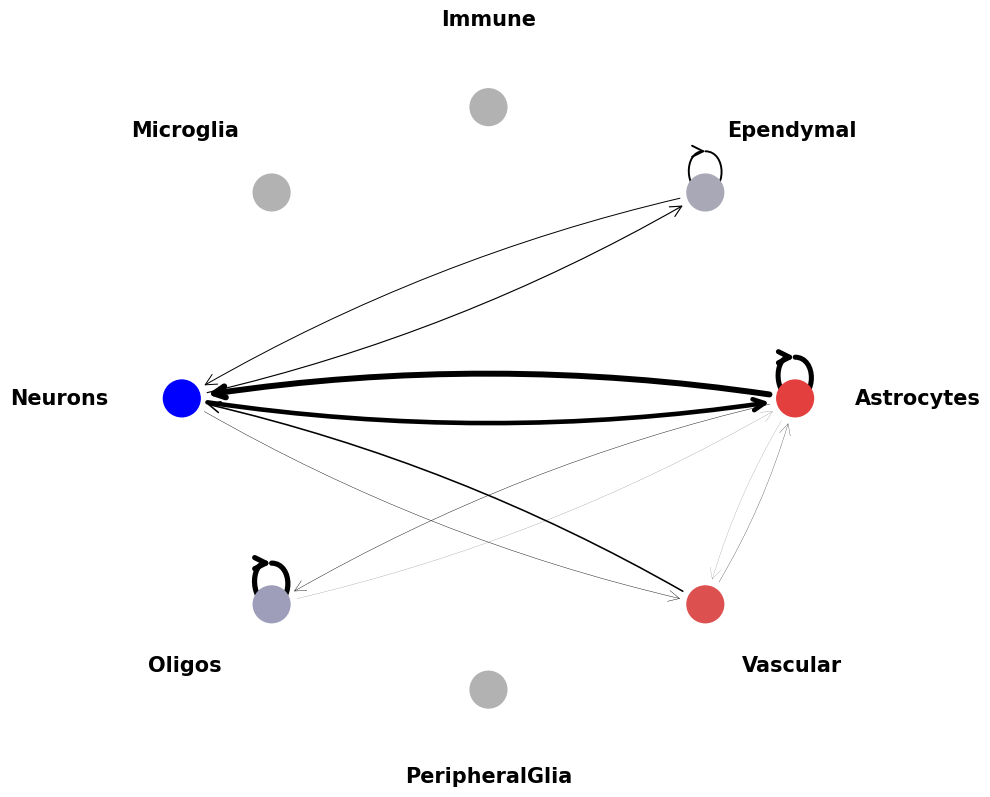


cluster1: Contains 53 LR pairs


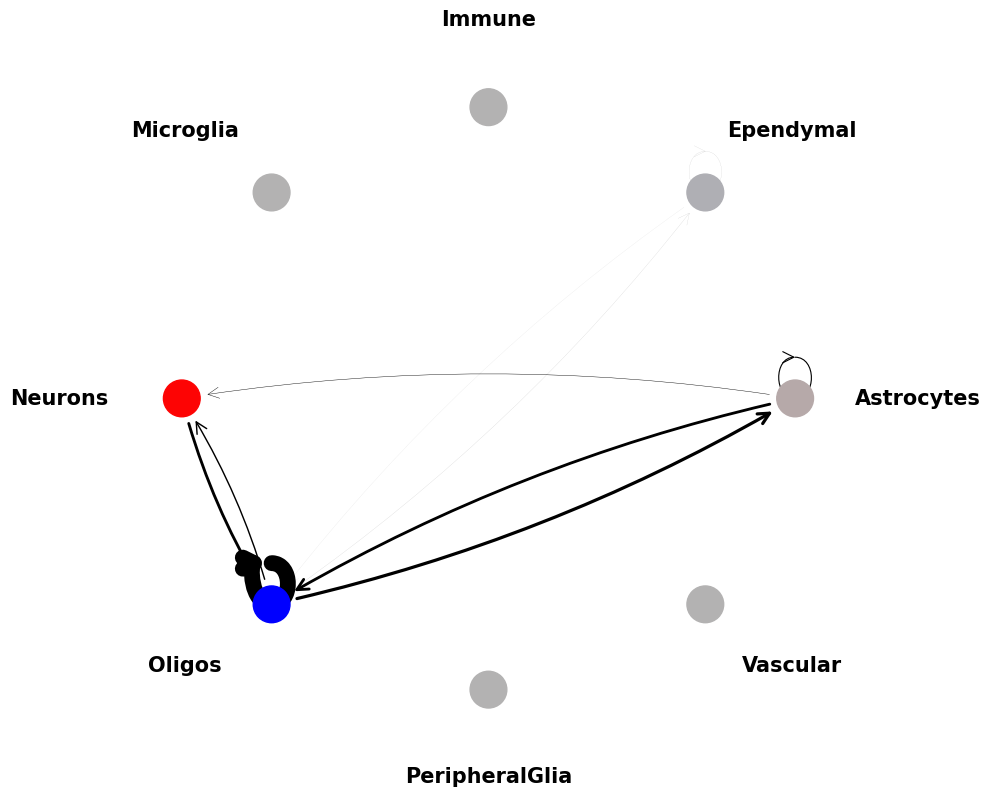


cluster2: Contains 49 LR pairs


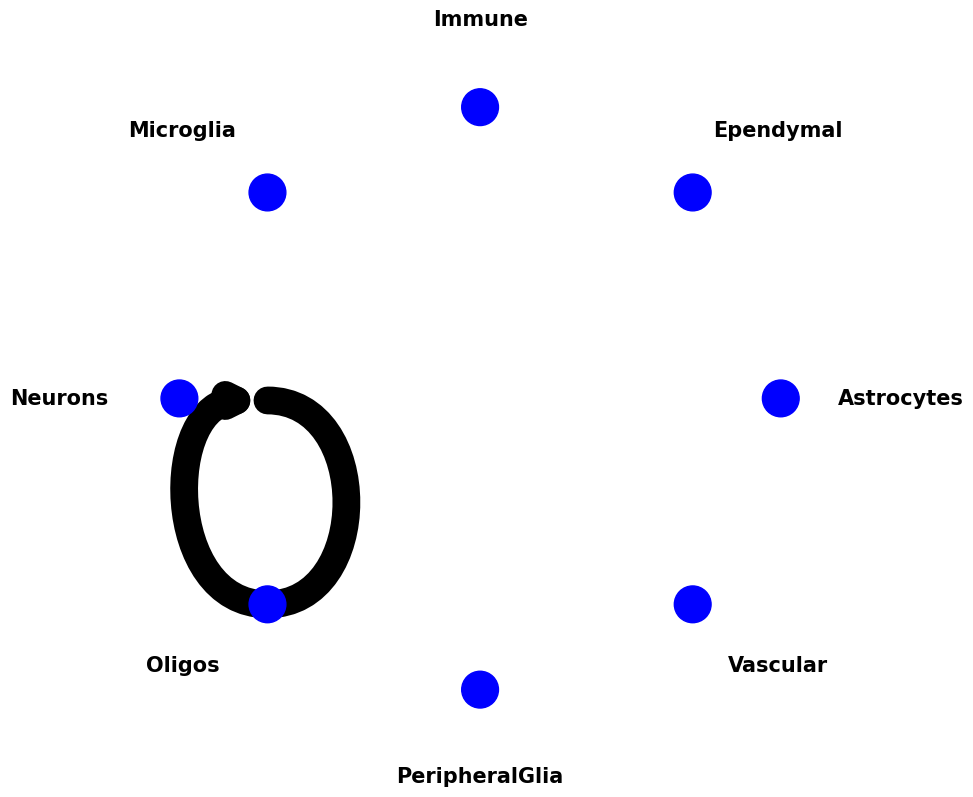


cluster3: Contains 47 LR pairs


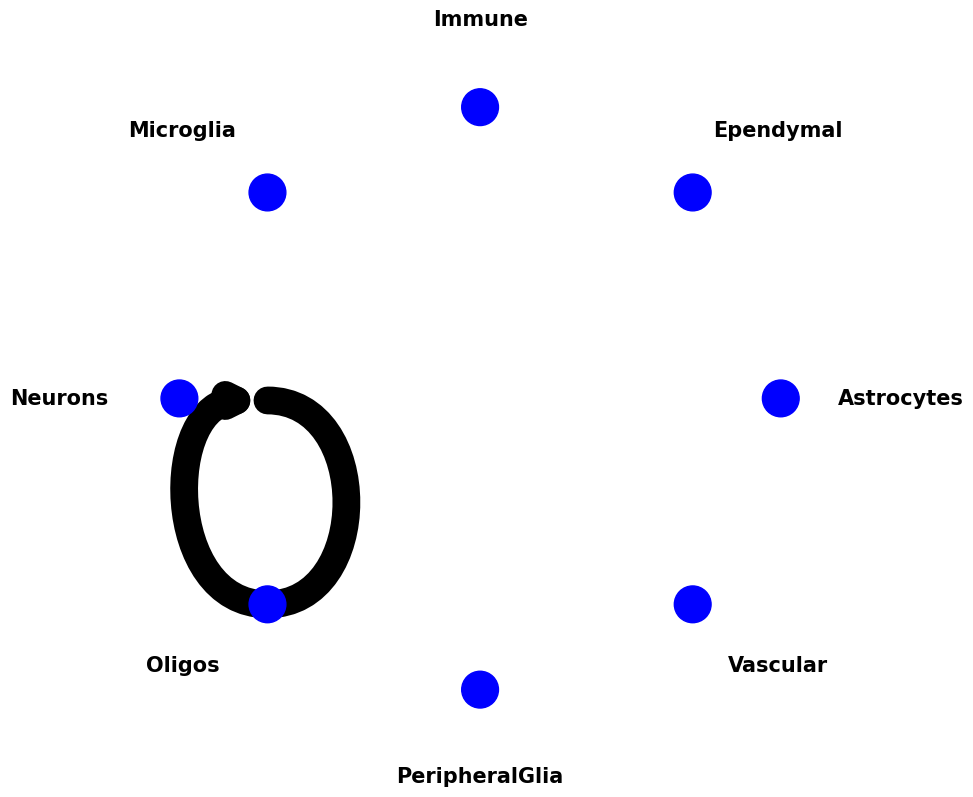


cluster4: Contains 27 LR pairs


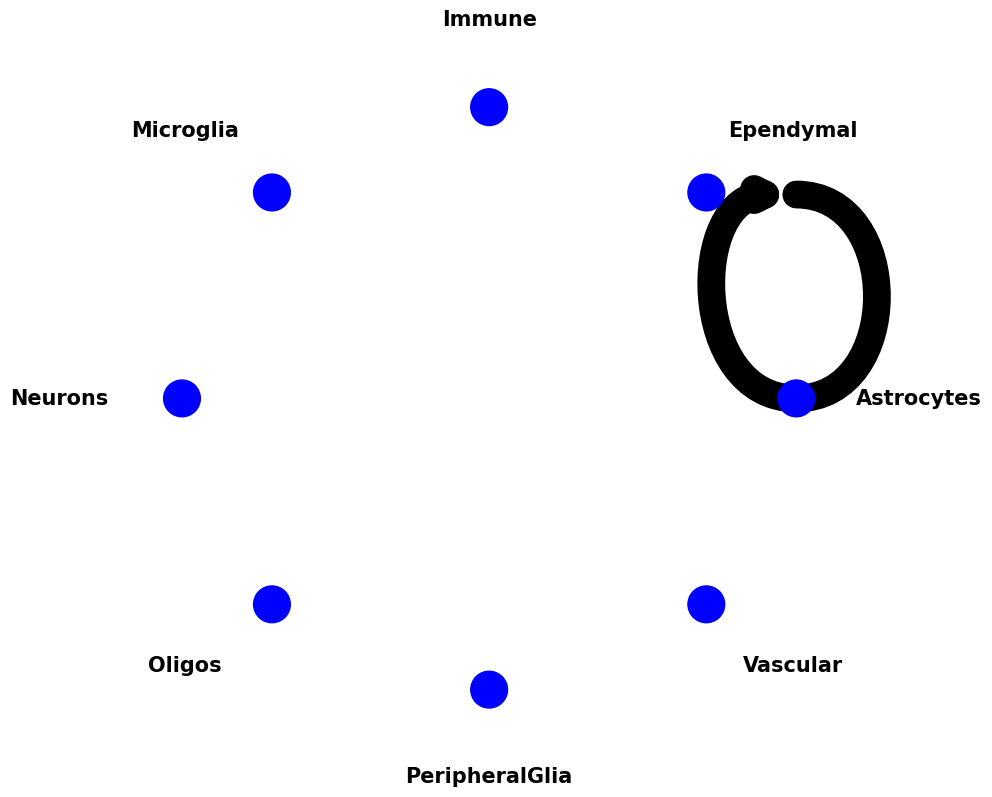


cluster5: Contains 31 LR pairs


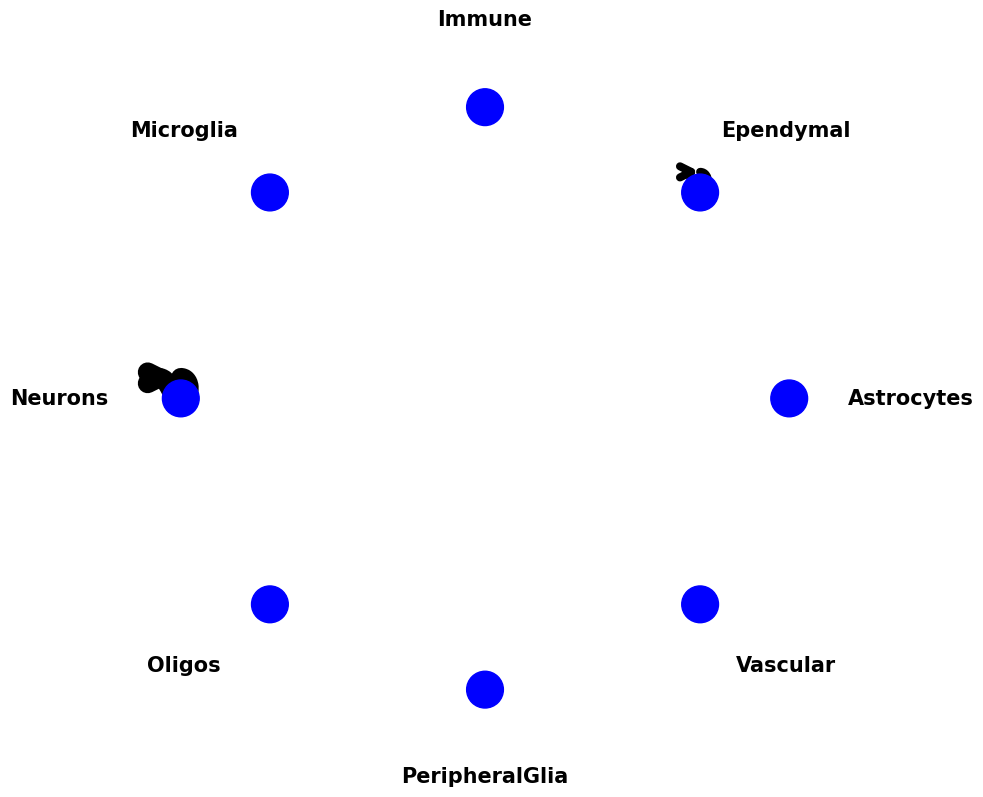

In [19]:
for cluster, matrix in aged_overall_clusters.items():
    print("\ncluster" + str(cluster) + ": Contains " + str(len(aged_integrated_clusters[cluster])) + " LR pairs")
    mmcci.plt.network_plot(matrix)

Computing Dissimilarity Scores for multiple interactions...


Processing: 100%|██████████| 37/37 [00:00<00:00, 75.04it/s]


Computing Principal Components of weighted graph ...
Performing Clustering and Ranking within clusters...


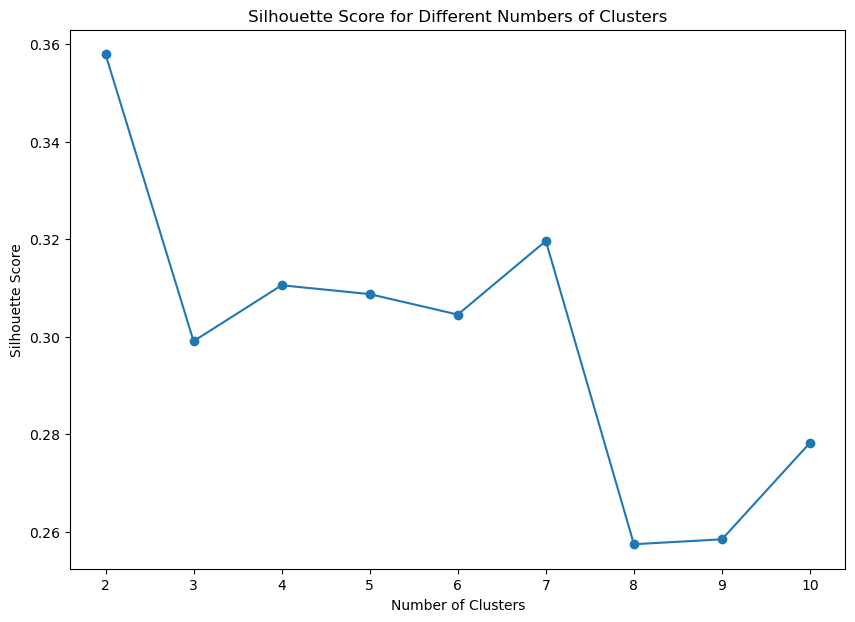

Computing Dissimilarity Scores for single interactions...


Processing: 100%|██████████| 98/98 [00:03<00:00, 24.84it/s]


Computing Principal Components of weighted graph ...
Performing Clustering and Ranking within clusters...


In [20]:
young_clusters = mmcci.an.lr_grouping(young_integrated, n_clusters=0)
young_integrated_clusters = mmcci.an.subset_clusters(young_integrated, young_clusters)
young_overall_clusters = mmcci.an.calculate_cluster_interactions(young_integrated_clusters)


cluster0: Contains 26 LR pairs


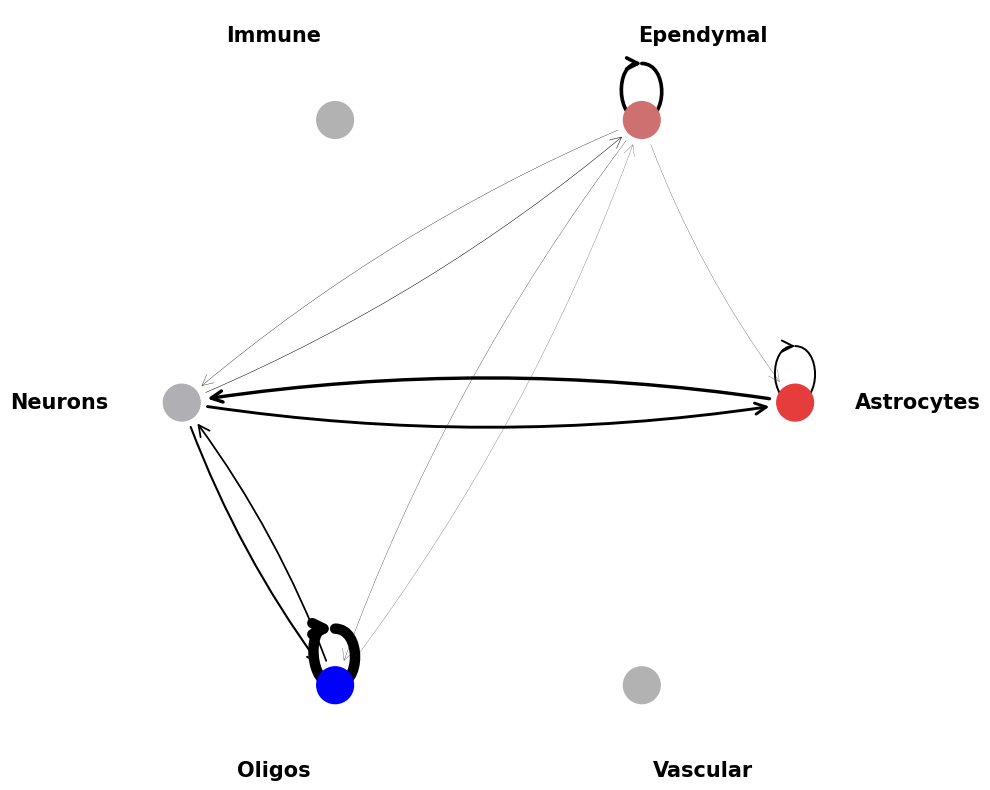


cluster1: Contains 11 LR pairs


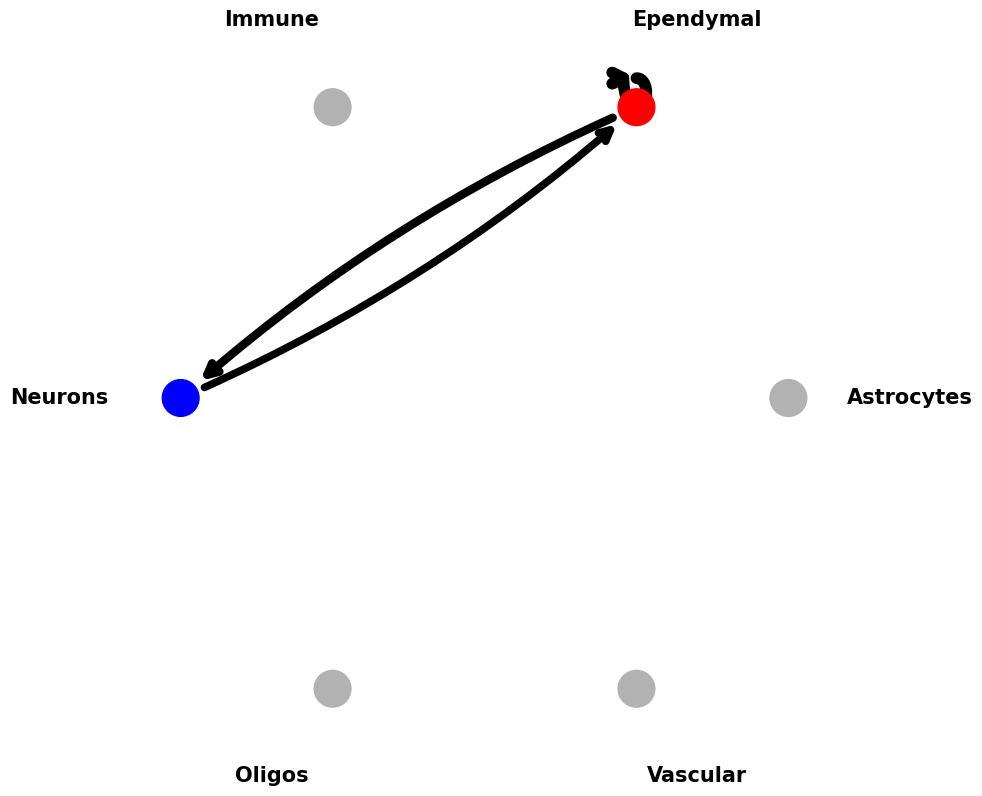


cluster2: Contains 37 LR pairs


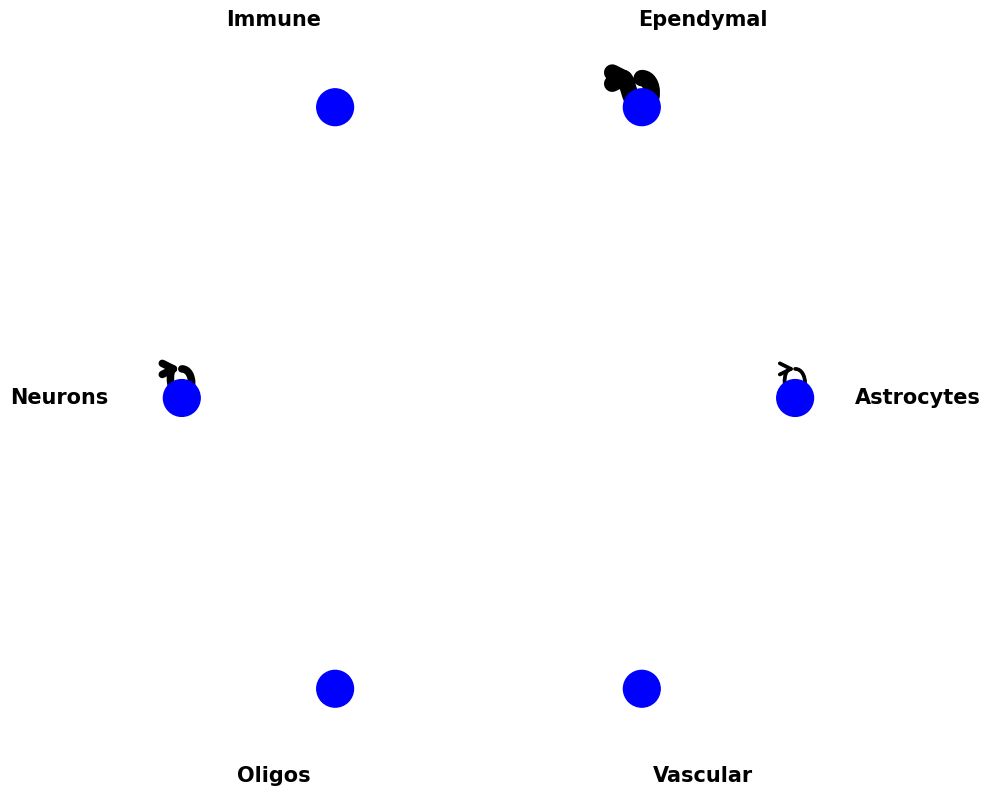


cluster3: Contains 61 LR pairs


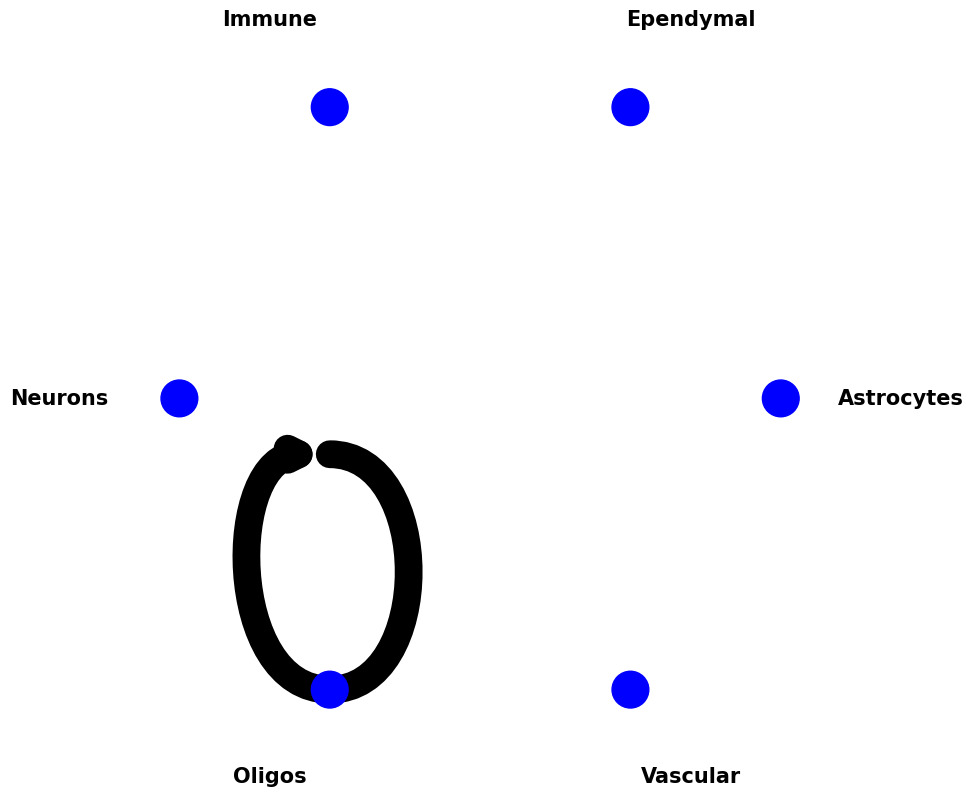

In [21]:
for cluster, matrix in young_overall_clusters.items():
    if matrix is not None:
        print("\ncluster" + str(cluster) + ": Contains " + str(len(young_integrated_clusters[cluster])) + " LR pairs")
        mmcci.plt.network_plot(matrix)

#### Run GSEA Analysis on Clusters

/home/uqlhocke/micromamba/envs/py-env/lib/python3.9/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/uqlhocke/micromamba/envs/py-env/lib/python3.9/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/uqlhocke/micromamba/envs/py-env/lib/python3.9/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/uqlhocke/micromamba/envs/py-env/lib/python3.9/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Epithelial Mesenchymal Transition,25/200,2.058022e-28,8.026285e-27,0,0,38.081081,2427.693193,NOTCH2;ITGB1;LRP1;SERPINE2;SDC4;LAMA2;LAMA1;FB...
1,MSigDB_Hallmark_2020,Angiogenesis,6/36,2.179519e-08,4.250063e-07,0,0,42.733333,753.883364,LRPAP1;VTN;LPL;ITGAV;VEGFA;FGFR1
2,MSigDB_Hallmark_2020,UV Response Dn,8/144,5.853843e-07,7.609996e-06,0,0,12.776341,183.353240,PDGFRB;COL1A1;NOTCH2;TGFBR3;COL1A2;FZD2;SDC2;CAV1
3,MSigDB_Hallmark_2020,Apoptosis,8/161,1.362950e-06,1.328876e-05,0,0,11.346980,153.250714,PDGFRB;TGFBR3;TGFB2;CAV1;BGN;PLAT;PSEN1;CD44
4,MSigDB_Hallmark_2020,Myogenesis,8/200,6.834697e-06,5.331064e-05,0,0,9.024267,107.330110,COL1A1;ITGB1;TGFB1;NOTCH1;LAMA2;PLXNB2;FGF2;HBEGF
...,...,...,...,...,...,...,...,...,...,...
195,KEGG_2021_Human,Human immunodeficiency virus 1 infection,1/212,6.527138e-01,6.693435e-01,0,0,0.952220,0.406233,GNAI2
196,KEGG_2021_Human,cAMP signaling pathway,1/216,6.596123e-01,6.721366e-01,0,0,0.934314,0.388771,GNAI2
197,KEGG_2021_Human,Thermogenesis,1/232,6.858755e-01,6.945028e-01,0,0,0.868893,0.327624,FGFR1
198,KEGG_2021_Human,Parkinson disease,1/249,7.115841e-01,7.160315e-01,0,0,0.808632,0.275147,GNAI2


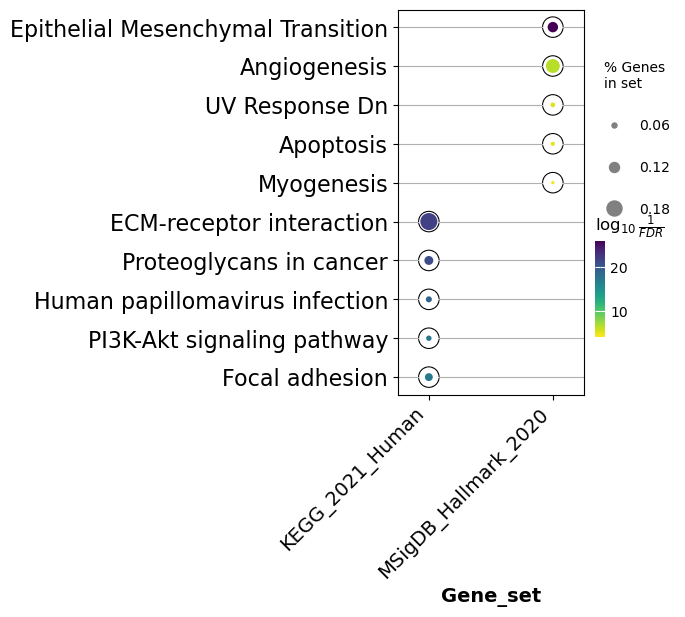

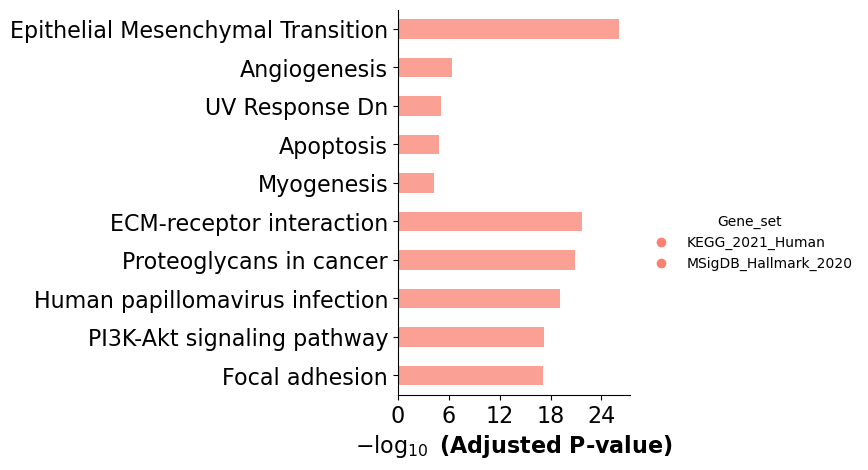

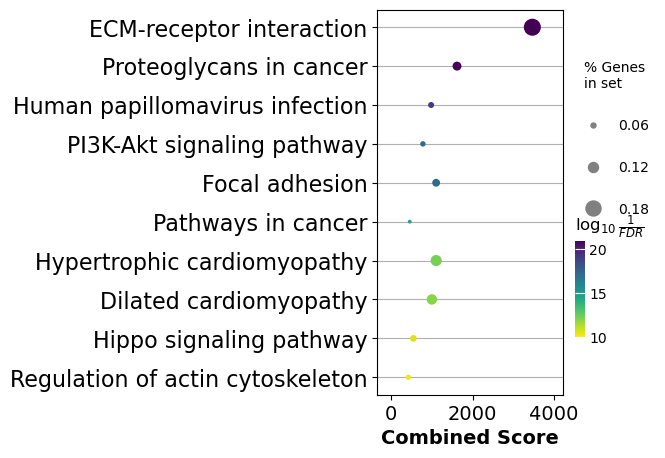

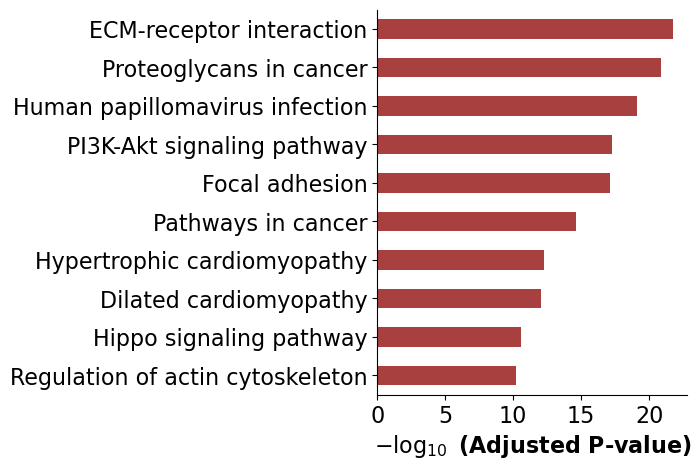

In [22]:
mmcci.an.run_gsea(aged_integrated_clusters[0])